In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from random import shuffle
from collections import Counter
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Image settings
IMG_SIZE = 150
DATASET_DIR = 'Festival of Nepal'
LABELS = ['Chhath', 'Dashain', 'Holi', 'Teej', 'Tihar']
X = []
Z = []

In [3]:
# Load dataset
def assign_label(img, label):
    return label

def make_train_data(label, DIR):
    for img_name in tqdm(os.listdir(DIR)):
        label_val = assign_label(img_name, label)
        path = os.path.join(DIR, img_name)
        img = cv2.imread(path)
        try:
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            X.append(np.array(img))
            Z.append(str(label_val))
        except Exception as e:
            pass

for label in LABELS:
    make_train_data(label, os.path.join(DATASET_DIR, label))

# Label encoding
le = LabelEncoder()
Y = le.fit_transform(Z)
Y = to_categorical(Y, len(LABELS))

X = np.array(X)

  0%|          | 1/250 [00:00<00:35,  7.06it/s]

100%|██████████| 250/250 [00:03<00:00, 73.87it/s] 


In [4]:
# Train/test split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [5]:
# ImageDataGenerator (normalization + augmentation)
datagen = ImageDataGenerator(
    # rescale=1./255,
    rotation_range=35,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)
datagen.fit(x_train)

In [6]:
# Load EfficientNetB0 base model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [7]:
# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
# x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)
predictions = Dense(len(LABELS), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5)
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)


In [8]:
# Train the model
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=64),
    validation_data=(x_test, y_test),
    epochs=100,
    callbacks=[early_stop],
    verbose=1
)

c:\Users\Lenovo\OneDrive\Desktop\ANN\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.2144 - loss: 1.6942 - val_accuracy: 0.3480 - val_loss: 1.5029
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.3202 - loss: 1.5384 - val_accuracy: 0.5440 - val_loss: 1.3242
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.4761 - loss: 1.3483 - val_accuracy: 0.6240 - val_loss: 1.1936
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.5396 - loss: 1.2217 - val_accuracy: 0.6400 - val_loss: 1.0896
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.6005 - loss: 1.1408 - val_accuracy: 0.6720 - val_loss: 1.0077
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 73s 5s/step - accuracy: 0.6470 - loss: 1.0690 - val_accuracy: 0.6840 - val_loss: 0.9428
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 0.6398 - loss: 1.0069 - val_accuracy: 0.7080 - val_loss: 0.8951
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.6580 - loss: 0.9544 - val_accuracy: 0.7280 - v

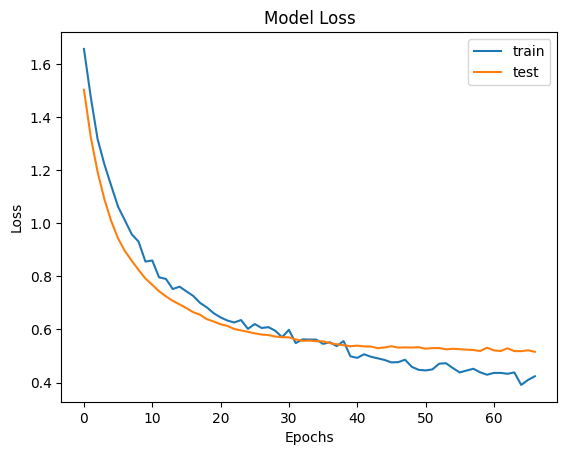

<Figure size 640x480 with 0 Axes>

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()
plt.savefig('loss_curve.png')


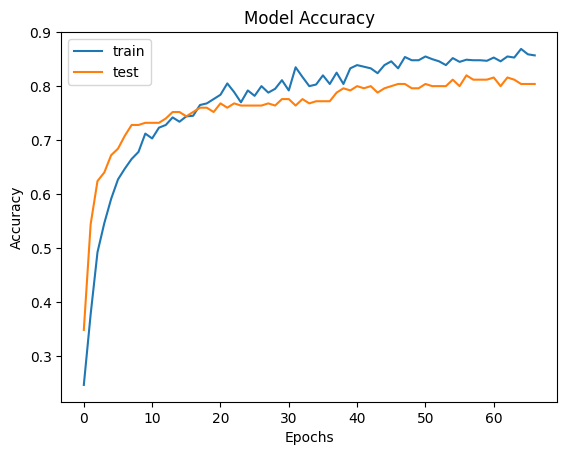

<Figure size 640x480 with 0 Axes>

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()
plt.savefig('accuracy_curve.png')

In [11]:
# getting predictions on val set.
pred=model.predict(x_test)
pred_digits=np.argmax(pred,axis=1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 878ms/step


In [12]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==pred_digits[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

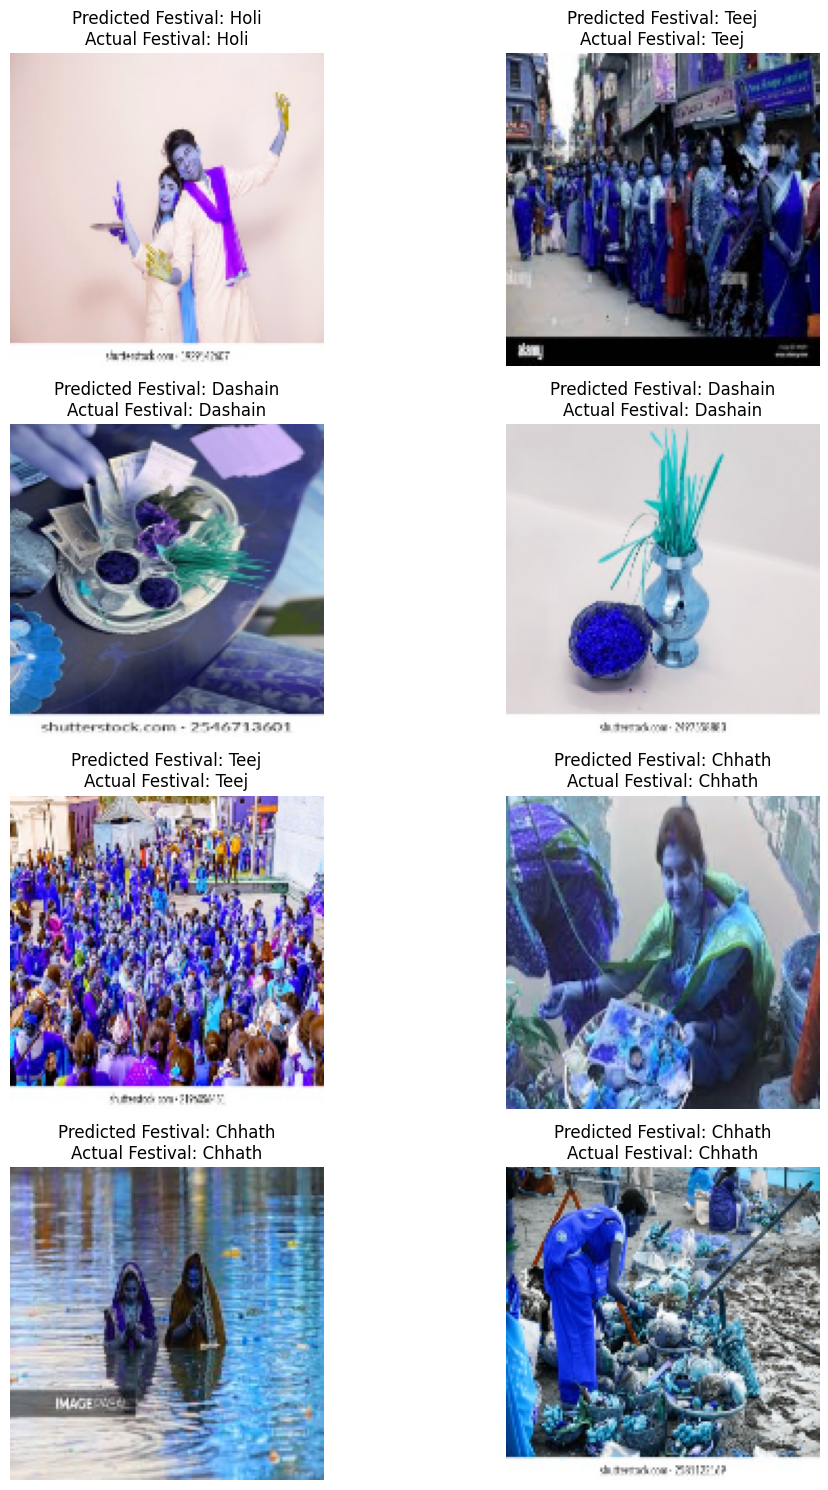

<Figure size 640x480 with 0 Axes>

In [20]:
import matplotlib.pyplot as plt
import warnings

# Ignore warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# Plot predictions
count = 0
fig, ax = plt.subplots(4, 2)
fig.set_size_inches(15, 15)

for i in range(4):
    for j in range(2):
        ax[i, j].imshow(x_test[prop_class[count]])
        ax[i, j].set_title(
            "Predicted Festival: " + str(le.inverse_transform([pred_digits[prop_class[count]]])[0]) + "\n" +
            "Actual Festival: " + str(le.inverse_transform([np.argmax(y_test[prop_class[count]])])[0])
        )
        ax[i, j].axis('off')  # Hide axis ticks
        plt.tight_layout()
        count += 1

plt.show()
plt.savefig('correct_prds.png')


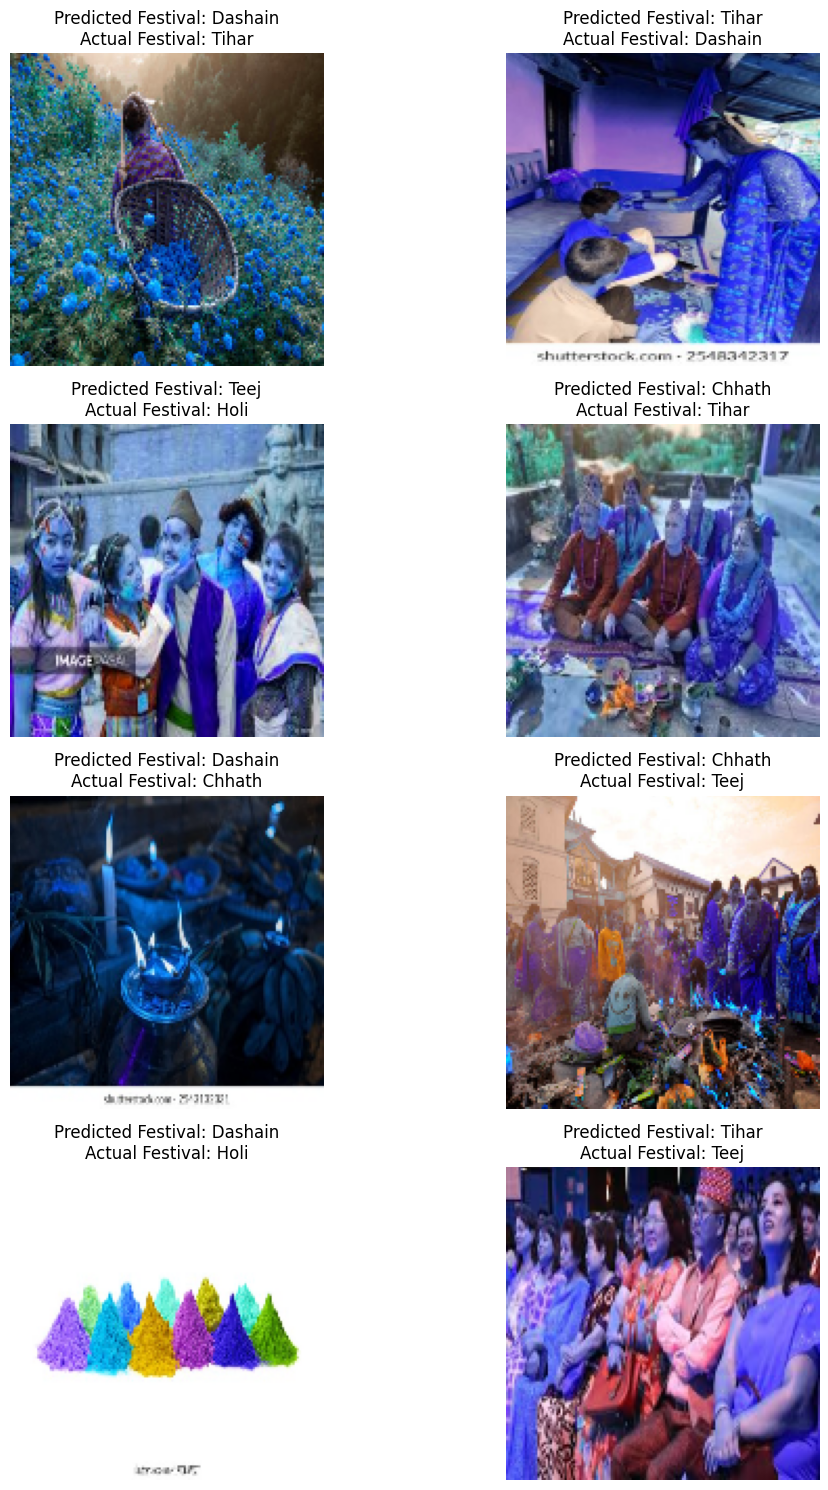

<Figure size 640x480 with 0 Axes>

In [21]:
import matplotlib.pyplot as plt
import warnings

# Ignore warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# Plot misclassified predictions
count = 0
fig, ax = plt.subplots(4, 2)
fig.set_size_inches(15, 15)

for i in range(4):
    for j in range(2):
        index = mis_class[count]
        ax[i, j].imshow(x_test[index])
        ax[i, j].set_title(
            "Predicted Festival: " + str(le.inverse_transform([pred_digits[index]])[0]) + "\n" +
            "Actual Festival: " + str(le.inverse_transform([np.argmax(y_test[index])])[0])
        )
        ax[i, j].axis('off')  # Hide axes
        plt.tight_layout()
        count += 1

plt.show()
plt.savefig('misclassified_preds.png')


8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 566ms/step


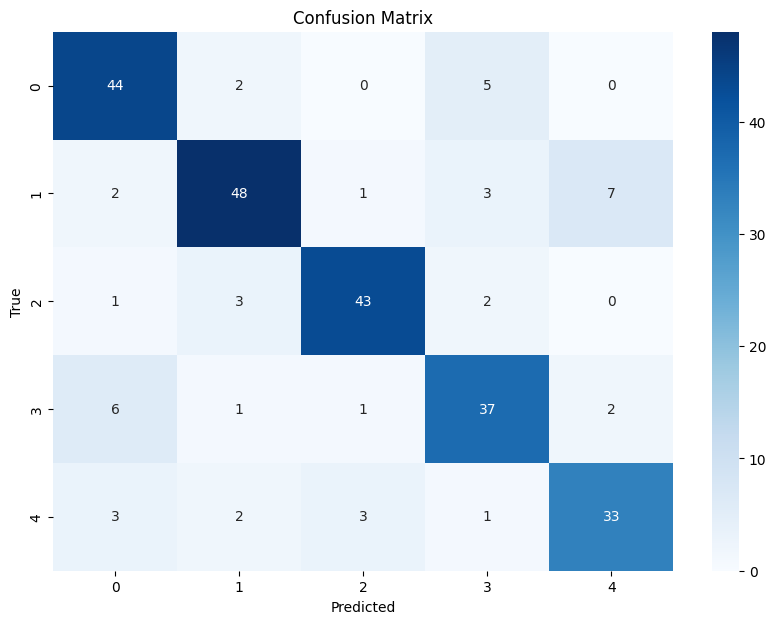

<Figure size 640x480 with 0 Axes>

In [19]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Predict on the test set
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class labels

# Get true labels
y_true = np.argmax(y_test, axis=1)  # If y_test is one-hot encoded

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(0, cm.shape[1]), yticklabels=np.arange(0, cm.shape[0]))
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
plt.savefig('confusion_matrix.png')

In [16]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(y_true, y_pred_classes)

# Print the classification report
print(report)


              precision    recall  f1-score   support

           0       0.79      0.86      0.82        51
           1       0.86      0.79      0.82        61
           2       0.90      0.88      0.89        49
           3       0.77      0.79      0.78        47
           4       0.79      0.79      0.79        42

    accuracy                           0.82       250
   macro avg       0.82      0.82      0.82       250
weighted avg       0.82      0.82      0.82       250

